# Beta distribution fit for amplitude distribution of TREK-2
similar proceudre like Indra Schroeder 
https://doi.org/10.1080/19336950.2015.1083660

1. Choose transition rates: open level determined by slow rates
2. Generate Gillespie trajectory (contunuous time) and resample it (discrete time) with sampling step << experimental re-sampling step 
3. Add noise with standard deviation according to noise level of closed state
4. Bessel filter with cut-off frequency 5 kHz.
5. Re-sample the signal with 200 kHz 
6. Generate amplitude histogram of simulated data and compare to experimental data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

import time
import random
import networkx as nx
import os

from scipy.stats import norm
from scipy import signal

import sys
path='../'
sys.path.append(path)
import Functions_Gillespie_Trajectory_Resampled as Gillespie
path='../../Markov_Models/Bibliotheken/'
res2 = os.listdir(path)
print(res2)
sys.path.append(path)
import Steady_State_Calculation_Spanning_Trees as auto

['Steady_State_Calculation_Spanning_Trees.py', 'Kinesin_Parameters.py', 'Analytic_Quantities.py', 'histogram.eps', 'PDF_Flux_entropy.py', '__pycache__']


In [401]:
T = 1.5 # length of trajectory
sampling_step = 2e-7 # sampling length for continuous Gillespie trajectory
order = 4 # order of Bessel filter
cutoff_fs = 5e3 # Hz
sampling_fs = 1/sampling_step # Hz
ReSamplingFreq = 200e3; # like in exmperimental set-up
ReSamplingStep = 1/ReSamplingFreq;
print('resolvable frequencies: ', 0.2*cutoff_fs , ' = 1/5*cut-off freq')

current_level = -58
closed_level = -1.625
sigma_closed = 19.4 #2.1e-2 # noise level of closed state (noise added before filtering)
sigma_convolution = 0.72 # noise added via convolution after fitlering
print('level of added noise before filtering equivalent to covolution with narrow Gaussian')


resolvable frequencies:  1000.0  = 1/5*cut-off freq
level of added noise before filtering equivalent to covolution with narrow Gaussian


# 1. Choose transition rates
open level determined by slow rates

$P_o = \dfrac{A[0][3]}{A[0][3] + A[3][0] }$

closed level determined by slow rates

$P_c = \dfrac{A[3][0]}{A[0][3] + A[3][0] } + \dfrac{A[3][1]}{A[1][3] + A[3][1] } + \dfrac{A[3][2]}{A[2][3] + A[3][2] }$

A = 
 [[    0.     0.     0.   900.]
 [    0.     0.     0.  4500.]
 [    0.     0.     0. 60000.]
 [  300.  5000. 33000.     0.]]
steady state p =  [0.11131725 0.37105751 0.18367347 0.33395176]
Number of bins 272
min:  -79.835 ; max:  9.59500000000001


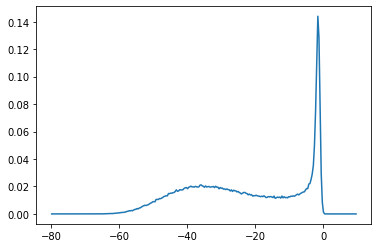

In [436]:
A=np.zeros((4,4))
# state 0: closed state slow
# state 1: closed state fast
# state 2: closed state medium
# state 3: open state

# slow = 0
A[0][3] = 1e2 * 9  # exit rate closed slow
A[3][0] = 1e2 * 3  # dominant for open dwell time 

# medium = 1
A[1][3] = 1e3 * 4.5  # exit rate closed medium
A[3][1] = 1e3 * 5

# fast = 2
A[2][3] = 1e3 * 60   # exit rate closed fast
A[3][2] = 1e3 * 33

print('A = \n', A)
G=auto.Matrix2Graph(A)
p=auto.steady_state(G)
print('steady state p = ',p)

# Read experimental data
mV = -200
folder2 = '../../SUBSTATES_differentFreq/fixedEdges/'
fname_N = folder2 + str(int(cutoff_fs/1e3)) + 'kHz_' + str(mV) + 'mV_N.txt'
fname_edges = folder2 +  str(int(cutoff_fs/1e3)) + 'kHz_' + str(mV) + 'mV_edges.txt'
exp_N = np.loadtxt(fname_N);
exp_edges = np.loadtxt(fname_edges)

plt.plot(exp_edges, exp_N)
print('Number of bins', len(exp_edges))
print('min: ', min(exp_edges), '; max: ', max(exp_edges))

# write out matrix
np.savetxt(str(int(cutoff_fs/1e3)) + 'kHz_'+str(mV)+'_mV_TransitionMatrix.txt', A)

# 2. Generate Gillespie trajectory (contunuous time) and resample it (discrete time) with sampling step << experimental re-sampling step  

In [437]:
[prob, sample_states] = Gillespie.simulation_traj(matrix=A, startState=0, T=T, sampling_step=sampling_step)

sample_indistinguishable = sample_states.copy()
# set state 3 zo current level -1
index = sample_states == -1
sample_indistinguishable[index] = current_level
index = sample_states == 3
sample_indistinguishable[index] = current_level

# make state 0 and 1, 2 indistinguishable
index = sample_states == 0
sample_indistinguishable[index] = closed_level
index = sample_states == 1
sample_indistinguishable[index] = closed_level
index = sample_states == 2
sample_indistinguishable[index] = closed_level


print('steady state p = ',p)
print('Gillespie prob = ', prob)
N = len(sample_states)
print('sample states N = ', N)
print('sample states min = ', sample_states.min())
print('sample states max = ', sample_states.max())
print('indistinguishable states min = ', sample_indistinguishable.min())
print('indistinguishable states max = ', sample_indistinguishable.max())
state0 = np.count_nonzero(sample_states == 0)
state1 = np.count_nonzero(sample_states == 1)
state2 = np.count_nonzero(sample_states == 2)
state3 = np.count_nonzero(sample_states == 3)
error = np.count_nonzero(sample_states == -1)
print('number of -1 states (error)', error, 'in percent', error/N)
p_sample = [state0/N, state1/N, state2/N ,state3/N ]
print('p_sample = ', p_sample)

number of Gillespie steps 38102
number of sample steps  7480189
number of transitions not seen by sample step 358
steady state p =  [0.11131725 0.37105751 0.18367347 0.33395176]
Gillespie prob =  [0.12333874 0.36509444 0.18205739 0.32941262]
sample states N =  7500000
sample states min =  -1.0
sample states max =  3.0
indistinguishable states min =  -58.0
indistinguishable states max =  -1.625
number of -1 states (error) 19811 in percent 0.0026414666666666666
p_sample =  [0.12332866666666667, 0.36492986666666666, 0.18096186666666667, 0.32813813333333336]


# 3. Add noise with standard deviation according to noise level of closed state

In [438]:
# Adding noise
print('length of sampled states = ', N)
std_noise1 = sigma_closed
noise1 = np.random.normal(0, sigma_closed,N)
print('std. dev. of noise ', np.std(noise1))
print(len(noise1))
print(len(sample_states))
signal_noise1 = sample_indistinguishable + noise1

std_noise2 = 0.02
noise2 = np.random.normal(0, std_noise2,N)
signal_noise2 = sample_indistinguishable + noise2

print(np.unique(sample_indistinguishable))

length of sampled states =  7500000
std. dev. of noise  19.396301070664897
7500000
7500000
[-58.     -1.625]


# 4. 4-pole Bessel filter with cut-off frequency 5 kHz.

sampling freq =  5000000.0
sampling step =  2e-07


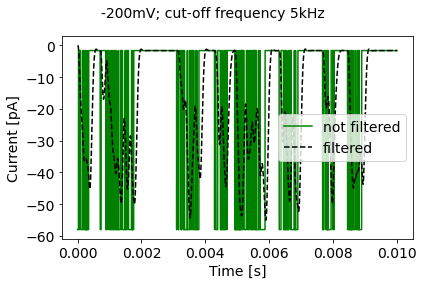

In [441]:
print('sampling freq = ', sampling_fs)
print('sampling step = ', sampling_step)

# For analog filters, Wn is an angular frequency (e.g., rad/s).
# For digital filters, Wn are in the same units as fs.
[b, a] =  signal.bessel(order, Wn=cutoff_fs, btype='low', analog=False, output='ba', norm='phase', fs=sampling_fs)
#output{‘ba’, ‘zpk’, ‘sos’}, optional
#Type of output: numerator/denominator (‘ba’), pole-zero (‘zpk’), or second-order sections (‘sos’). 
sos = signal.bessel(order, Wn=cutoff_fs, btype='low', analog=False, output='sos', norm='phase', fs=sampling_fs)

y_tf = signal.lfilter(b, a, sample_indistinguishable)
y_sos = signal.sosfilt(sos, sample_indistinguishable)

y_sos_noise1 = signal.sosfilt(sos, signal_noise1)
y_tf_noise1 = signal.lfilter(b, a, signal_noise1)

subset = int(0.01 * 1/sampling_step )
f_size =  14
fig, ax = plt.subplots()
fig.suptitle(str(mV)+'mV; ' +'cut-off frequency ' + str(int(cutoff_fs/1e3)) + 'kHz', fontsize=f_size)
t = np.arange(0,T,sampling_step)
ax.plot(t[0:subset], sample_indistinguishable[0:subset], color='green', label='not filtered')
#ax.plot(t[0:subset], signal_noise1[start:start+subset], color='blue', label='noise: $\sigma$ = %.2f' %sigma_closed, alpha=0.7)
#ax.plot(t[0:subset], y_tf[0:subset], 'r--', label='TF') # diverges for order = 8
ax.plot(t[0:subset], y_sos[0:subset], '--', color='black', label='filtered')
ax.set_xlabel('Time [s]', fontsize=f_size)
ax.set_ylabel('Current [pA]', fontsize=f_size)
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 14})
#ax.set_ylim([-1.1, 0.3])
fig.tight_layout()
fig.savefig( str(int(cutoff_fs/1e3)) + 'kHz_'+'timeseries.pdf')
plt.show()

# 5. Re-sample the signal with 200 kHz
# 6. Generate amplitude histogram of simulated data and compare to experimental data

sampling step =  2e-07
ReSamplingStep =  5e-06
downsampling step =  25
length of exp_edges =  272

closed peak
noise and filtered  0.1620999999999977
filtered  and convolution 0.1593015529410912
experimental 0.143977716849202


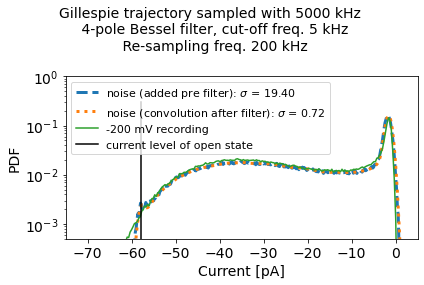

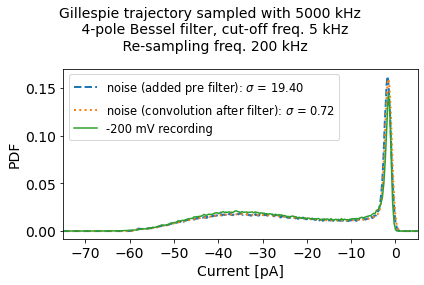

In [498]:
binning = np.arange(-80, 10,0.2)#exp_edges # 200
print('sampling step = ', sampling_step)
print('ReSamplingStep = ', ReSamplingStep)
downsampling = int(ReSamplingStep/sampling_step)
print('downsampling step = ', downsampling )
print('length of exp_edges = ', len(exp_edges))
#bins = exp_edges
# Generate amplitude histograms
[hist, bin_edges] = np.histogram(sample_indistinguishable[0::downsampling], density=True) # not filtered
[hist1, bin_edges1] = np.histogram(signal_noise1[0::downsampling], density=True, bins=100) # not filtered
[hist_f, bin_edges_f]=np.histogram(y_sos[0::downsampling], density=True, bins=binning) # filtered
[hist_n_f, bin_edges_n_f]=np.histogram(y_sos_noise1[0::downsampling], density=True, bins=binning) # filtered
[tf_hist_n_f, tf_bin_edges_n_f]=np.histogram(y_tf_noise1[0::downsampling], density=True, bins=binning) #filtered

# Add noise with convolution
rv1 = norm(loc = 0., scale = sigma_convolution)
dx1 = bin_edges_f[2]-bin_edges_f[1]
x = np.arange(-10, 10, dx1)
noise = rv1.pdf(x) 
filtered = signal.convolve(hist_f, noise, mode='same') / sum(noise)


fig, ax = plt.subplots()
fig.suptitle('Gillespie trajectory sampled with %d kHz \n 4-pole Bessel filter, cut-off freq. 5 kHz\n Re-sampling freq. %d kHz' %(int(sampling_fs/1e3) , int(ReSamplingFreq/1e3)), fontsize=f_size)
#ax.plot(bin_edges[:-1], hist, label = 'no noise and not filtered')
#ax.plot(bin_edges1[:-1], hist1, label='noise: $\sigma$ = %.2f' %sigma_closed)

#ax.plot(bin_edges_f[:-1], hist_f, '-', color='black', label = 'no noise and sos-filtered', linewidth=1)
ax.plot(bin_edges_n_f[:-1], hist_n_f, '--',  label='noise (added pre filter): $\sigma$ = %.2f' %sigma_closed, linewidth=3)
#ax.plot(tf_bin_edges_n_f[:-1], tf_hist_n_f, '--',  label='noise: $\sigma$ = %.2f and tf-filtered' %sigma_closed)
ax.plot(bin_edges_f[:-1], filtered, ':',  label='noise (convolution after filter): $\sigma$ = %.2f' %sigma_convolution, linewidth = 3)

ax.plot(exp_edges, exp_N, label = '%d mV recording' %mV)
ax.set_xlabel('Current [pA]', fontsize=f_size)
ax.set_ylabel('PDF', fontsize=f_size)
ax.set_xlim([-75, 5])
ax.set_ylim([5e-4, 1e0]) #3e-1
ax.plot([current_level, current_level], [1e-5, 3e-1] ,label='current level of open state', color='black')
ax.tick_params(axis='both', labelsize=f_size)
ax.set_yscale('log')
ax.legend(prop={'size': 11}, loc='upper left')
plt.tight_layout()
#plt.savefig(str(int(cutoff_fs/1e3)) + 'kHz_' +str(mV)+'_mV_log.pdf', bbox_inches='tight')

# no log scale
fig, ax = plt.subplots()
fig.suptitle('Gillespie trajectory sampled with %d kHz \n 4-pole Bessel filter, cut-off freq. 5 kHz\n Re-sampling freq. %d kHz' %(int(sampling_fs/1e3) , int(ReSamplingFreq/1e3)), fontsize=f_size)
#ax.plot(bin_edges_f[:-1], hist_f, '-', color='black', label = 'no noise and sos-filtered', linewidth=1)
ax.plot(bin_edges_n_f[:-1], hist_n_f, '--',  label='noise (added pre filter): $\sigma$ = %.2f' %sigma_closed, linewidth=2)
ax.plot(bin_edges_f[:-1], filtered, ':',  label='noise (convolution after filter): $\sigma$ = %.2f' %sigma_convolution, linewidth=2)
ax.plot(exp_edges, exp_N, label = '%d mV recording' %mV)
ax.set_xlabel('Current [pA]', fontsize=f_size)
ax.set_ylabel('PDF', fontsize=f_size)
ax.set_xlim([-75, 5])
#ax.set_ylim([0, 8])
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 11.5}, loc='upper left')
plt.tight_layout()
#plt.savefig(str(int(cutoff_fs/1e3)) + 'kHz_' +str(mV)+'_mV.pdf', bbox_inches='tight')

print()
print('closed peak')
print('noise and filtered ', max(hist_n_f))
print('filtered  and convolution', max(filtered))
print('experimental', max(exp_N))

# write out trajectories
#np.savetxt(str(int(cutoff_fs/1e3)) + 'kHz_'+str(mV)+'_mV_noNoise.txt', y_sos[0::downsampling])
#np.savetxt(str(int(cutoff_fs/1e3)) + 'kHz_'+str(mV)+'_mV_Noise.txt', y_sos_noise1[0::downsampling])
#N_down = len(sample_indistinguishable[0::downsampling] )
#traj =  sample_indistinguishable[0::downsampling] + np.random.normal(0, sigma_convolution,N_down)
#np.savetxt(str(int(cutoff_fs/1e3)) + 'kHz_'+str(mV)+'_mV_NoFilter_BaselineNoise.txt', traj)

# Add noise with convolution

0.20000000000000284 0.20000000000000284
length of noise  100
length of hist_f  449


<ipython-input-382-aefa4d4608a8>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


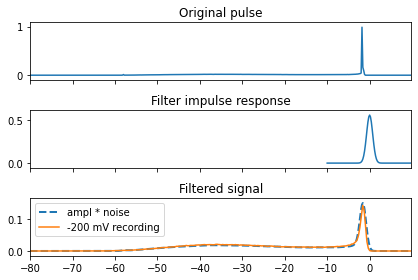

In [382]:
# make vectors equi-distant
dx1 = bin_edges_f[2]-bin_edges_f[1]
dx2 = bin_edges_f[10]-bin_edges_f[9]
print(dx1, dx2)

rv1 = norm(loc = 0, scale = sigma_convolution)#
x = np.arange(-10, 10, dx1)#np.linspace(-.3, 0.3, len(hist_f))
noise = rv1.pdf(x) 
print('length of noise ', len(noise))
filtered = signal.convolve(hist_f, noise, mode='same') / sum(noise)
filtered2 = signal.convolve(noise,hist_f, mode='same') / sum(hist_f)

print('length of hist_f ',len(hist_f))

fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(bin_edges_f[:-1], hist_f)
#ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)

ax_win.plot(x, noise)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)

ax_filt.plot(bin_edges_f[:-1], filtered, '--', label='ampl * noise', linewidth=2)
#ax_filt.plot(bin_edges_f[:-1], filtered2, label='noise * ampl')
ax_filt.plot(exp_edges, exp_N, label = '%d mV recording' %mV)
ax_filt.legend(loc='upper left')
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()

sum of weighting factor  4.99999999999993


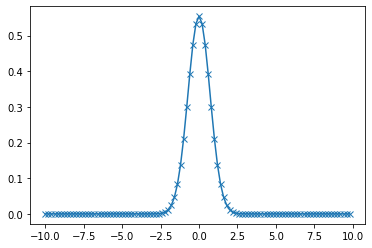

In [383]:
print('sum of weighting factor ', sum(noise))
plt.plot(x, noise, '-x')

# Filter added noise
compare standard deviation before and after

In [478]:
print('length of sampled states = ', N)
std_noise1 = sigma_closed
noise1 = np.random.normal(0, sigma_closed,N)
print('std. dev. of noise ', np.std(noise1))

# filter
noise_tf = signal.lfilter(b, a, noise1)
noise_sos = signal.sosfilt(sos, noise1)
print('std. dev. of noise after filtering', np.std(noise_tf))
print('std. dev. of noise after filtering', np.std(noise_sos))

#downsampling
noise_tf = signal.lfilter(b, a, noise1)
noise_sos = signal.sosfilt(sos, noise1)
print('std. dev. of noise after filtering and downsampling', np.std(noise_tf[0::downsampling]))
print('std. dev. of noise after filtering and downsampling', np.std(noise_sos[0::downsampling]))

length of sampled states =  7500000
std. dev. of noise  19.393039965355634
std. dev. of noise after filtering 0.7216698588119295
std. dev. of noise after filtering 0.7216697724712247
std. dev. of noise after filtering and downsampling 0.7216696933597756
std. dev. of noise after filtering and downsampling 0.7216696070188512


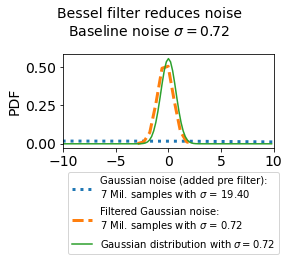

In [492]:
[hist_noise1, bin_edges_noise1] = np.histogram(noise1, density=True) # not filtered
[hist_noise2, bin_edges_noise2] = np.histogram(noise_sos, density=True) # filtered
[hist_noise3, bin_edges_noise3] = np.histogram(noise_sos[0::downsampling], density=True) # filtered and downsampled

rv1 = norm(loc = 0, scale = sigma_convolution)#
x = np.arange(-10, 10, dx1)#np.linspace(-.3, 0.3, len(hist_f))
noise = rv1.pdf(x) 

fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Bessel filter reduces noise\nBaseline noise $\sigma=$'+str(sigma_convolution), fontsize=f_size)

ax.plot(bin_edges_noise1[:-1], hist_noise1, ':',  label='Gaussian noise (added pre filter):\n%d Mil. samples with $\sigma$ = %.2f' %(N/1000000, sigma_closed), linewidth=3)
ax.plot(bin_edges_noise2[:-1], hist_noise2, '--',  label='Filtered Gaussian noise: \n%d Mil. samples with $\sigma$ = %.2f' %(N/1000000, np.std(noise_sos)), linewidth=3)
ax.plot(x, noise, label = 'Gaussian distribution with $\sigma = %.2f$' %sigma_convolution)


#ax.set_xlabel('Current [pA]', fontsize=f_size)
ax.set_ylabel('PDF', fontsize=f_size)
ax.set_xlim([-10, 10])
#ax.set_ylim([5e-4, 1e0]) #3e-1
ax.tick_params(axis='both', labelsize=f_size)
#ax.set_yscale('log')
ax.legend(prop={'size': 10}, loc='upper left', bbox_to_anchor=(0.0, -0.2)) # bbox_to_anchor=(1.05, 1)
plt.tight_layout()
plt.savefig(str(int(cutoff_fs/1e3)) + 'kHz_' +str(mV)+'_mV_NoiseLevelComparison.pdf', bbox_inches='tight')